In [94]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [95]:
#defining directories for the tasks
CURR_DIR=os.getcwd()

TRAIN_DIR=os.path.join(CURR_DIR,"data/train")
TEST_DIR=os.path.join(CURR_DIR,"data/test")

train_cat_dir=os.path.join(TRAIN_DIR,"cat")
train_dog_dir=os.path.join(TRAIN_DIR,"dog")

test_cat_dir=os.path.join(TEST_DIR,"cat")
test_dog_dir=os.path.join(TEST_DIR,"dog")

In [96]:
print(f"Total training cat images:{len(os.listdir(train_cat_dir))}")
print(f"Total training dog images:{len(os.listdir(train_dog_dir))}")
print(f"Total testing cat images:{len(os.listdir(test_cat_dir))}")
print(f"Total testing dog images:{len(os.listdir(test_dog_dir))}")

Total training cat images:9922
Total training dog images:9979
Total testing cat images:2575
Total testing dog images:2515


In [ ]:
#defining the neural network model
model=tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    #defining 3 CNN
    tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),

    #flatenning the output features to 1-d vector for Dense layer
    tf.keras.layers.Flatten(),

    #Dense layer to compute
    tf.keras.layers.Dense(128,activation='relu'),

    #randomly drops the fatures(sets to 0) enforcing other pattern to be caught by the model
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 74, 74, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 36, 36, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 34, 34, 256)     

In [98]:
#compiling the model for reducing the loss
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [99]:
#instatiate training dataset
train_dataset=tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(150,150),
    batch_size=32,
    color_mode="rgb",
    label_mode='binary'
)

#instatiating the test dataset
test_dataset=tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(150,150),
    batch_size=32,
    color_mode="rgb",
    label_mode='binary'
)

Found 19901 files belonging to 2 classes.
Found 5090 files belonging to 2 classes.


In [100]:
#configuring the dataset for easier execution from second epoch
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final=(train_dataset
                     .cache()
                     .shuffle(SHUFFLE_BUFFER_SIZE)
                     .prefetch(PREFETCH_BUFFER_SIZE))
test_dataset_final=(test_dataset
                     .cache()
                     .shuffle(SHUFFLE_BUFFER_SIZE)
                     .prefetch(PREFETCH_BUFFER_SIZE))

In [101]:
#callback to stop training once model gets 95% accuracy
class stop_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95:
            self.model.stop_training = True
            print("Model got 95% accuracy so stopping training")

callback=stop_callback()

In [103]:
history=model.fit(train_dataset_final,
                  epochs=10,
                  validation_data=test_dataset_final,
                  verbose=1,
                  callbacks=[callback])

Epoch 1/10
622/622 [==============================] - 846s 1s/step - loss: 0.6596 - accuracy: 0.5963 - val_loss: 0.5543 - val_accuracy: 0.7287
Epoch 2/10
622/622 [==============================] - 833s 1s/step - loss: 0.5148 - accuracy: 0.7489 - val_loss: 0.4691 - val_accuracy: 0.7790
Epoch 3/10
622/622 [==============================] - 818s 1s/step - loss: 0.4155 - accuracy: 0.8118 - val_loss: 0.3407 - val_accuracy: 0.8462
Epoch 4/10
622/622 [==============================] - 821s 1s/step - loss: 0.3421 - accuracy: 0.8494 - val_loss: 0.3216 - val_accuracy: 0.8568
Epoch 5/10
622/622 [==============================] - 822s 1s/step - loss: 0.2803 - accuracy: 0.8818 - val_loss: 0.3040 - val_accuracy: 0.8747
Epoch 6/10
622/622 [==============================] - 826s 1s/step - loss: 0.2337 - accuracy: 0.9022 - val_loss: 0.3420 - val_accuracy: 0.8538
Epoch 7/10
622/622 [==============================] - 832s 1s/step - loss: 0.1916 - accuracy: 0.9223 - val_loss: 0.2815 - val_accuracy: 0.8939

In [104]:
model.save("cat_or_dog.h5")
print("Model saved sucessfully")

c:\Users\akash\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved sucessfully


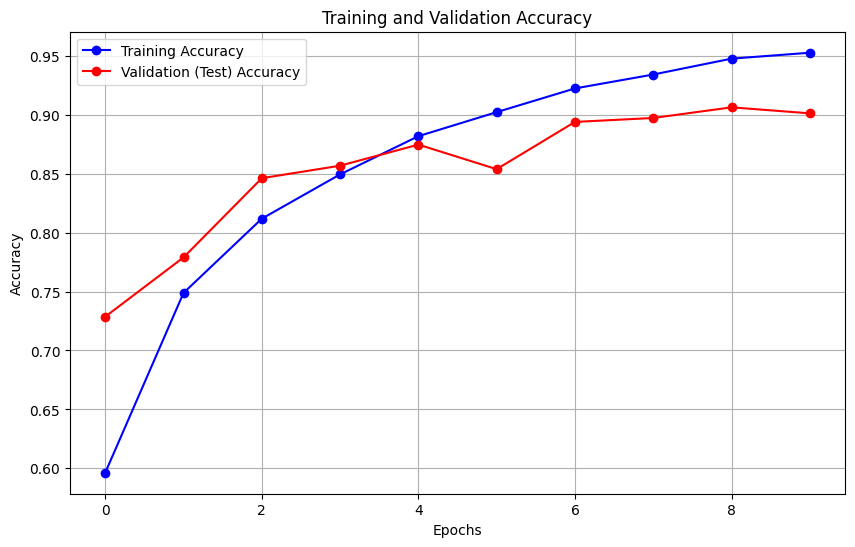

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.figure(figsize=(10, 6)) 
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation (Test) Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True) 
plt.show()

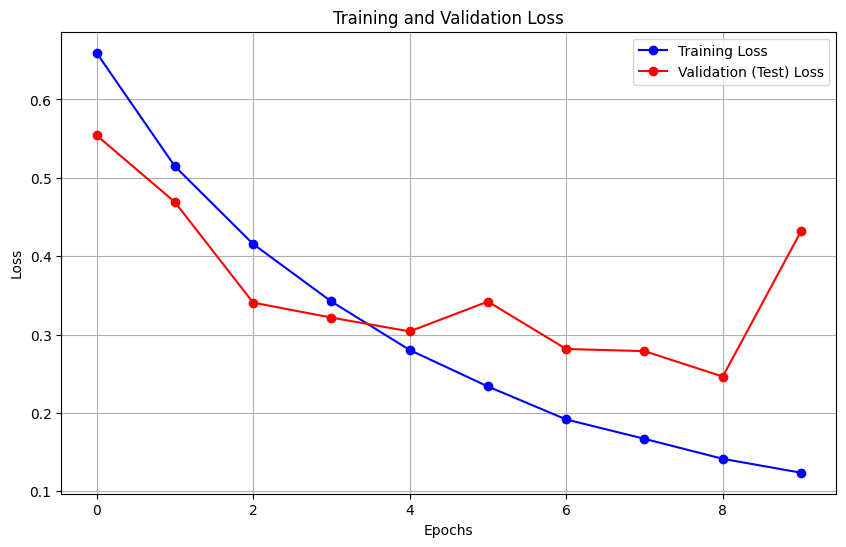

In [106]:

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation (Test) Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()